# Feature Extraction

 ## Harris Corner Detector

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2 
import skimage.io
import os

(300, 300)


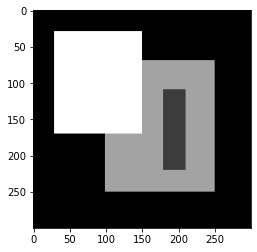

In [2]:
gen = os.getcwd()
path = '\week06_data\TestIm1.png'
I1 = skimage.io.imread(gen + path).astype(float)
I1 = I1[:,:,0]
# I1_inv = np.invert(I1)
print(I1.shape)

fig, ax = plt.subplots()
ax.imshow(I1, cmap='gray')
# ax[1].imshow(I_inv, cmap='gray')

In [3]:
s = 10

In [4]:
def gaussian1DKernel(sigma:int, scale:int = 5):
    """
    sigma: stadard deviation of the gaussian distribution.
    scale: Range of x times the stadard deviatiion for the x values where we'll evaluate the gaussian.    
    Scale fixed to 5, following the rule of 3std = 99.7% of the data. We make sure we have at least that much.
    
    g: Gaussian distribution given a variance. Column Vector -> (n,1)
    gx: Gaussian distribution derivative given a variance. Column Vector -> (n,1)
    
    If instead of doing it 1D we were doing 2D Kerels, would be much more computational expensive
    from run time O(2*n) --> O(n^2)
    """
    # Width of the Gaussian
    h = np.ceil(scale*sigma)
    x = np.arange(-h, h+1)
    # Cte of the Gaussian
    c = (1)/(np.sqrt(2*np.pi)*sigma)
    c_exp = np.exp((-x**2)/(2*sigma**2))
    # Gaussian equation 
    g = c*c_exp
    # First derivative
    gx = (-x/sigma**2)*g
    # Reshape to (n,1)
    g, gx = g.reshape(-1,1), gx.reshape(-1,1)
    
    return g, gx    

Text(0.5, 1.0, 'First Derivative Gaussian')

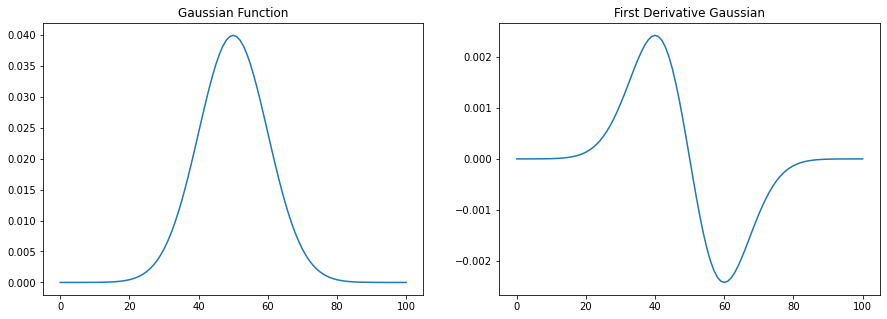

In [5]:
g, gx = gaussian1DKernel(s)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(g)
ax[0].set_title('Gaussian Function')
ax[1].plot(gx)
ax[1].set_title('First Derivative Gaussian')

In [6]:
def gaussianSmoothing(im, sigma, scale:int=5):
    """
    Gaussian convoltion on a given image. Being g a column vector (n,1)
    I = g*g.T*I
    Ix = d/dx(g.T)*I*g
    Iy = d/dy(g)*I*g.T 
    # Remember they are comutative
    
    im: Image we want to convolve.
    sigma: the variance of the gaussian distribution. In case we want to change it, by default 5
    scale: The the scale we want to analyise the gaussian distribution
    """
    g, gx = gaussian1DKernel(sigma, scale)
    
    I = cv2.filter2D(cv2.filter2D(im, -1, g.T), -1, g)  # convolution on x then in y
    Ix = cv2.filter2D(cv2.filter2D(im, -1, gx.T), -1, g) # convolution with dervative en x direcion then convolve
#   in y direction
    Iy = cv2.filter2D(cv2.filter2D(im, -1, gx), -1, g.T) # convolution with dervative en y direcion then convolve 
#   in x direction
    # ddepth has to do with which kind of informarion on the pixel we want, 8bytes, 16 bytes
       
    return I, Ix, Iy

Text(0.5, 0.98, 'Normal Image')

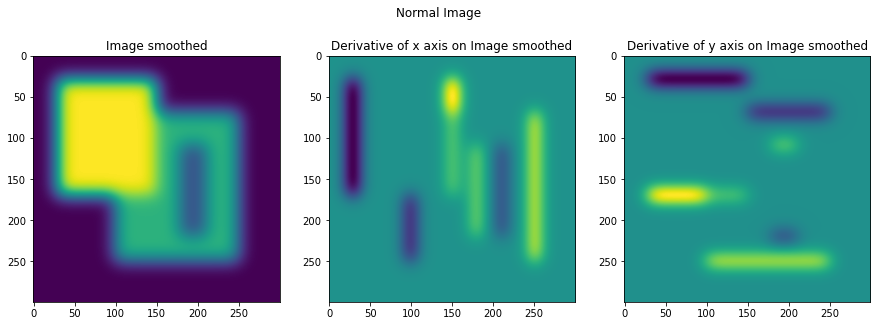

In [7]:
I,Ix,Iy = gaussianSmoothing(I1, s)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(I)
ax[0].set_title('Image smoothed')
ax[1].imshow(Ix)
ax[1].set_title('Derivative of x axis on Image smoothed')
ax[2].imshow(Iy)
ax[2].set_title('Derivative of y axis on Image smoothed')
fig.suptitle('Normal Image')

### Why we are only detecting edges on the right part on the x derivative and on the lower part on the y derivative??

In [8]:
# I_inv,Ix_inv,Iy_inv = gaussianSmoothing(I1_inv, s)
# fig, ax = plt.subplots(1,4, figsize=(15,5))
# ax[0].imshow(I1_inv, cmap='gray')
# ax[0].set_title('Image')
# ax[1].imshow(I_inv)
# ax[1].set_title('Smoothed')
# ax[2].imshow(Ix_inv)
# ax[2].set_title("g'(x)/dx Image smoothed")
# ax[3].imshow(Iy_inv)
# ax[3].set_title("g'(y)/dy Image smoothed")
# fig.suptitle('Inverted Image')

### If we use the inverse of the image we obtain the oposite edges

In [9]:
# Ix_p, Iy_p = (Ix+Ix_inv), (Iy+Iy_inv) 
# I_p = Ix_p + Iy_p
# fig, ax = plt.subplots(1,3, figsize=(15,5))

# ax[0].imshow(Ix_p)
# ax[0].set_title("g'(x)/dx Image smoothed")
# ax[1].imshow(Iy_p)
# ax[1].set_title("g'(y)/dy Image smoothed")
# ax[2].imshow(I_p)
# ax[2].set_title('Sum of both')
# fig.suptitle('Inverted Image')

In [10]:
def smoothHessian(im, sigma:int, epsilon:int):
    """
    Harris corner measure. Where * means convolution:
        C(x,y) = g*ΔI(x,y)^2 = g*(I(x,y)-I(x+Δx,y+Δy))^2
    We replace the last term with taylor expansion:
        I(x+Δx,y+Δy) =~ I(x,y) - dI/dx(x,y)Δ_x - dI/dy(x,y)Δ_y
    We can assume:
        dI/dx(x,y) = Ix
        dI/dy(x,y) = Iy 
    We can rewrite it as:
        I(x+Δx,y+Δy) = I(x,y) - [Ix Iy][Δ_x Δ_y].T  # Ix and Iy are values at (x,y)
    If we subsititute:
        C(x,y) = g*([Ix Iy][Δ_x Δ_y].T)^2 = g*([Δ_x Δ_y]x[Ix Iy].Tx[Ix Iy]x[Δ_x Δ_y].T) # x is normal multiplication.
    
    im: image we want to convolve.
    sigma: standard deviation we want to use in the gaussian.
    epsilon: The Gaussian Kernel width. 
    
    
    """
    I,Ix,Iy = gaussianSmoothing(im, sigma)
    ge, gxe = gaussian1DKernel(sigma, epsilon)
    
    
    C = np.zeros((2,2, *im.shape))
    C[0,0] = cv2.filter2D(cv2.filter2D(Ix**2, -1, ge.T), -1, ge)
    C[0,1] = cv2.filter2D(cv2.filter2D(Ix*Iy, -1, ge.T), -1, ge) 
    C[1,0] = cv2.filter2D(cv2.filter2D(Ix*Iy, -1, ge.T), -1, ge)
    C[1,1] = cv2.filter2D(cv2.filter2D(Iy**2, -1, ge.T), -1, ge)
    
    return C

In [11]:
C = smoothHessian(I1, s, 10)

In [12]:
def harrisMeasure(im, sigma:int, epsilon:int, k:int=0.06):
    
    C = smoothHessian(im, sigma, epsilon)
    r = C[0,0]*C[1,1]-C[0,1]**2-k*(C[0,0]+C[1,1])**2
       
    return r

In [13]:
s = 10 
e = 10 
r = harrisMeasure(I1, s, e)
# # r_inv = harrisMeasure(I_inv,s, e)
# fig, ax = plt.subplots(figsize=(15,5))
# ax.imshow(r)
# plt.colorbar(ax)
# r.shape

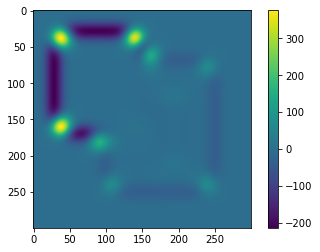

In [14]:
plt.imshow(r)
plt.colorbar()

In [15]:
r_max = np.max(r)

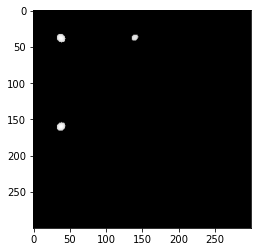

In [16]:
tau = 0.8*r_max

idx = np.where(r>tau)
r_t = np.zeros(I1.shape)
r_t[idx] = r[idx]
plt.imshow(r_t, cmap='gray')

In [17]:
R = (r_zeros[:-1,:] < r_zeros[1:,:])
R.shape
L = ~R
col = R.shape[1]
col
# falsy = np.array([False] * col)
# R = np.vstack([R, falsy])
# L = np.vstack([falsy, L])
# idx = np.where(R & L)



NameError: name 'r_zeros' is not defined

In [22]:
def cornerDetector(im, sigma:int, epsilon:int, k:int=0.06, tau:int=None):
    """
    Apply threshold 
    Apply Non maximum suppresion, then filter with threshold tau.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    """

        
    r = harrisMeasure(im, sigma, epsilon, k)
    
#     Create Threshold 
    if not tau:
        tau = 0.8*np.max(r)
        
    idx = np.where(r>tau)
    r_t = np.zeros(im.shape)
    r_t[idx] = r[idx]
    
    # Non maximum suppresion 
    # aplicar find peak from algorithms to sund peaks in each row and each column
#     r_cor = np.ones(im.shape)
    r_zeros = np.zeros(im.shape)
    
    # r(x, y) > r(x, y + 1)
    Up = (r_t[:-1,:] > r_t[1:,:])
    # r(x, y) ≥ r(x, y − 1) 
    Low = (r_t[:-1,:] <= r_t[1:,:])
    
    
    # r(x, y) > r(x + 1, y)
    R = (r_t[:,:-1] > r_t[:,1:])
    
    # r(x, y) ≥ r(x − 1, y)
    Lef = (r_t[:,:-1] <= r_t[:,1:])
    
    # Get columns
    col, row = im.shape
    
    # Create a row of false (if we want to consider the boudaries, we should use True )
    falsy_column = np.array([False] * row)
    falsy_row = np.array([False] * col)
    
    # Append Columns
    R = np.column_stack([R, falsy_column])
    Left = np.column_stack([falsy_column, Lef])
    Up = np.vstack([Up, falsy_row])
    Low = np.vstack([falsy_row, Low])

    
    # Get index when R and L are true 
    idx_x = np.where(R & Left)
    # Get index when Low and Up are true
    idx_y = np.where(Up & Low)
    # Cast all values that satisfy the condition to it's real value 
    r_zeros[idx_x] = r_t[idx_x]
    r_zeros[idx_y] = r_t[idx_y]
    
    
    
#     # r(x, y) > r(x, y + 1)
#     R = (r_zeros[:-1,:] < r_zeros[1:,:])
#     # r(x, y) ≥ r(x − 1, y)
#     L = ~R
    
    
        
#     # r(x, y) > r(x + 1, y)
#     idx_right = np.where(r_t[:-1,:] < r_t[1:,:])
#     r_cor[idx_right] = 0
    
#     # r(x, y) ≥ r(x − 1, y) 
#     idx_left = np.where(r_t[1:,:] <= r_t[:-1,:])
#     r_cor[idx_left] = 0
    
#     # r(x, y) > r(x, y + 1) ∧
#     idx_up = np.where(r_t[:,:-1] <= r_t[:,1:])
#     r_cor[idx_up] = 0
    
#     # r(x, y) ≥ r(x, y − 1) 
#     idx_down = np.where(r_t[:,1:] <= r_t[:,:-1])
#     r_cor[idx_down] = 0
    
# #     idx = np.where(r_cor == 1)
    
    
    
    ## 
    
#     Then once we have applies the non maximal supression we end with a matrix of 0 and 1, that can be seen as a matrix of true and False.
#  once we have that we should pass it into the matrix r en select only the true values, or the 1

    return r_zeros, R

In [23]:
r_c, R = cornerDetector(I1, 20, 20)

In [24]:
R

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

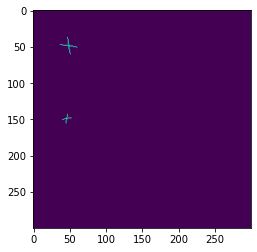

In [208]:
plt.imshow(r_c)

In [133]:
300*300

90000